_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student names: Stephan Amann, David Stefan Kleindiek, Hannah Blaurock

# Coding Lab 2

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations

from matplotlib.lines import Line2D

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-05-14 11:26:23CEST

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.24.0

sklearn: 1.4.2

scipy     : 1.13.0
matplotlib: 3.8.4
numpy     : 1.26.4

Watermark: 2.4.3



In [ ]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [ ]:
# replace by path to your solutions
b = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")
np.random.seed(0)

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [ ]:
def sample_data(
    n_samples: int, m: np.ndarray, S: np.ndarray, p: np.ndarray, random_seed: int = 2046
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # insert your code here

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (0.5 pt)
    # ------------------------------------------------------

    # number of clusters and dimensions
    n_clusters, n_dims = m.shape

    # draw cluster labels
    labels = rng.choice(n_clusters, size=n_samples, p=p)

    # samples array
    x = np.zeros((n_samples, n_dims))

    # draw samples for each cluster
    for i in range(n_clusters):
        # number of samples in cluster i
        n_samples_i = np.sum(labels == i)
        # draw samples from cluster i using corresponding mean and covariance
        x[labels == i] = rng.multivariate_normal(m[i], S[i], n_samples_i)

    return labels, x

In [ ]:
N = 1000  # total number of samples

p = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
m = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

labels, x = sample_data(N, m, S, p)

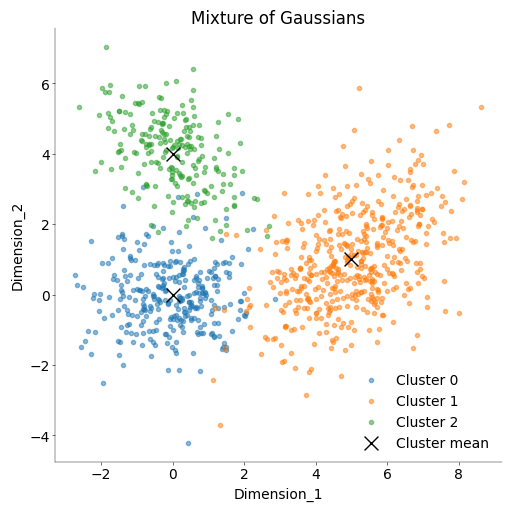

In [ ]:
# ----------------------------------------------
# plot points from mixture of Gaussians (0.5 pt)
# ----------------------------------------------

fig, ax = plt.subplots(figsize=(5, 5))

# plot points from each cluster with different color
for i in range(len(p)):
    # plot points of cluster i
    ax.scatter(
        x[labels == i, 0],
        x[labels == i, 1],
        alpha=0.5,
        label=f"Cluster {i}",
    )

    # plot cluster mean
    ax.scatter(m[i, 0], m[i, 1], c="k", marker="x", s=100)

# add label for mean symbol
ax.scatter([], [], c="k", marker="x", s=100, label="Cluster mean")

ax.set_xlabel("Dimension_1")
ax.set_ylabel("Dimension_2")
ax.set_title("Mixture of Gaussians")
ax.legend()

plt.show()

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 4 pts*


In [ ]:
def fit_mog(
    x: np.ndarray, n_clusters: int, n_iters: int = 10, random_seed: int = 2046
) -> tuple[np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """

    # ensure reproducibility using a random number generator
    rng = np.random.default_rng(random_seed)

    # fill in your code here

    # -----------
    # init (1 pt)
    # -----------
    n_samples, n_dims = x.shape
    # print("n_samples: ", n_samples)
    # print("n_dims: ", n_dims)

    # these are the initialization strategies we considered first:
    # # initialize means randomly, option 1 (uniformly):
    # m = rng.uniform(x.min(), x.max(), (n_clusters, n_dims))
    # # option 2 (use rng.choice):
    # # m = x[rng.choice(x.shape[0], n_clusters, replace=False)]

    # we decided to use kmeans++ for initialization as this is a state of the art initialization techinque and produces the best results
    # the implementation from scratch would be not feasable, therefore we used the sklearn function
    kmeans = KMeans(
        n_clusters=n_clusters,
        init="k-means++",  # ‘k-means++’ : selects initial cluster centroids using sampling based on an
        # empirical probability distribution of the points’ contribution to the overall inertia
        n_init=1,  # use 1 if init = k-means++, else just use 'auto'
        random_state=random_seed,
    )
    labels = kmeans.fit_predict(x)  # labels of each point?
    m = kmeans.cluster_centers_  # mean of the clusters (initialized by k_means++)
    S = np.stack(
        [np.cov(x[labels == i].T) for i in range(n_clusters)]
    )  # initialize covariance S_k
    p = np.array(
        [np.sum(labels == i) / n_samples for i in range(n_clusters)]
    )  # initialize mixing coefficient pi_k

    # -------------------------
    # EM maximisation (2.5 pts)
    # -------------------------
    for step in range(n_iters):
        # E step
        # Evaluate the posterior probablibities `r`
        # using the current values of `m` and `S`
        r = np.zeros((n_samples, n_clusters))

        for i in range(n_clusters):
            # compute the posterior for each cluster
            r[:, i] = p[i] * sp.stats.multivariate_normal.pdf(x, m[i], S[i])
        # normalize the posterior
        r /= np.sum(r, axis=1, keepdims=True)

        # M step
        # Estimate new `m`, `S` and `p`
        for i in range(n_clusters):
            # get number of points assigned to cluster i
            n_i = np.sum(r[:, i])

            # update the mean
            m[i] = np.sum(r[:, i][:, np.newaxis] * x, axis=0) / n_i

            # update the covariance
            S[i] = np.dot((x - m[i]).T, (x - m[i]) * r[:, i][:, np.newaxis]) / n_i

            # update the cluster weight
            p[i] = n_i / x.shape[0]

    # assign each point to the cluster with the highest posterior
    labels = np.argmax(r, axis=1)

    return labels, m, S, p

Run Mixture of Gaussian on toy data

In [ ]:
mog_labels, m, S, p = fit_mog(x, 3, random_seed=0)

Plot toy data with cluster assignments and compare to original labels

n_clusters in True: 3
n_clusters in MoG: 3


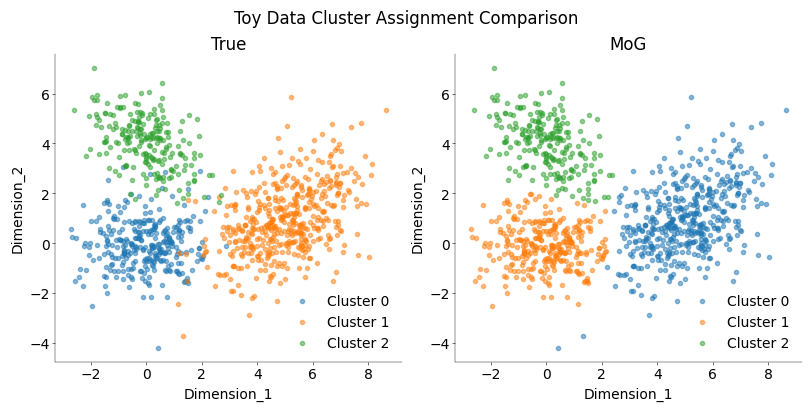

In [ ]:
mosaic = [["True", "MoG"]]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 4), layout="constrained")

# -----------------
# Add plot (0.5 pts)
# -----------------

label_list = [labels, mog_labels]
for i, mos in enumerate(mosaic[0]):
    n_clusters = np.unique(label_list[i]).size
    print("n_clusters in {}: {}".format(mos, n_clusters))  # should be the same for both

    for j in range(n_clusters):
        ax[mos].scatter(
            x[label_list[i] == j, 0],
            x[label_list[i] == j, 1],
            alpha=0.5,
            label=f"Cluster {j}",
        )

    ax[mos].set_title(mos)
    ax[mos].set_xlabel("Dimension_1")
    ax[mos].set_ylabel("Dimension_2")
    ax[mos].legend()

plt.suptitle("Toy Data Cluster Assignment Comparison")
plt.show()

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions for extra points. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 3 pts*



In [ ]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """

    # insert your code here

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    # number of clusters and dimensions
    n_clusters, n_dims = m.shape

    # number of samples
    n_samples = x.shape[0]

    # compute the log likelihood (slide 12, lecture 2)
    LL = 0
    for i in range(n_clusters):
        LL += p[i] * sp.stats.multivariate_normal.pdf(
            x,
            m[i],
            S[i],
        )
    LL = np.sum(np.log(LL))  # n values, taken log and summed

    # compute the BIC
    # Number of parameters in the model:
    bic = -2 * LL + (n_clusters * np.log(n_samples))

    return bic, LL


bic, LL = mog_bic(x, m, S, p)
print("BIC: ", bic)
print("LL: ", LL)

BIC:  8144.499618919815
LL:  -4061.888176541434


In [ ]:
# ---------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your algorithm robust against local minima. (0.5 pts) and plot the result (0.5 pts)
# ---------------------------------------------------------------------------------------------------

K = range(2, 7)
num_seeds = 10

# bunch of seeds
seeds = [104245, 2046, 42, 1337, 73084, 97893, 1234, 5678, 91011, 121314]

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here
for i, seed in enumerate(seeds):
    for j, k in enumerate(K):
        labels, m, S, p = fit_mog(x, k, random_seed=seed)
        BIC[i, j], LL[i, j] = mog_bic(x, m, S, p)

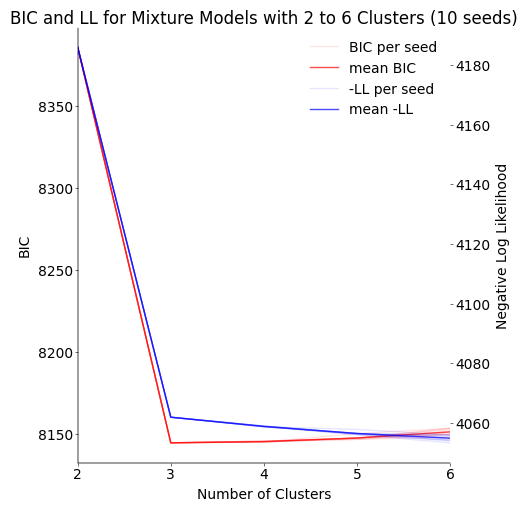

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax2 = ax.twinx()

for i, s in enumerate(seeds):
    ax.plot(K, BIC[i, :], c="r", alpha=0.1)
    ax2.plot(K, -LL[i, :], c="b", alpha=0.1)

# get mean per cluster size
mean_BIC = np.mean(BIC, axis=0)
mean_LL = np.mean(LL, axis=0)

# plot means
ax.plot(K, mean_BIC, c="r", alpha=0.7)
ax2.plot(K, -mean_LL, c="b", alpha=0.7)

# create legend
custom_lines = [
    Line2D([0], [0], color="r", alpha=0.1, lw=1),
    Line2D([0], [0], color="r", alpha=0.7, lw=1),
    Line2D([0], [0], color="b", alpha=0.1, lw=1),
    Line2D([0], [0], color="b", alpha=0.7, lw=1),
]

labels = ["BIC per seed", "mean BIC", "-LL per seed", "mean -LL"]
ax.legend(custom_lines, labels)
ax.set_xlim([K[0], K[-1]])
ax.set_xticks(K)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("BIC")
ax2.set_ylabel("Negative Log Likelihood")
plt.title(
    "BIC and LL for Mixture Models with {} to {} Clusters ({} seeds)".format(
        K[0], K[-1], num_seeds
    )
)
plt.show()

We can see that the optimal number of clusters is at 3, as BIC is lowest for that number of clusters. There is almost no standard deviation for the values of BIC or LL here, as our algorithm always yields the same results on the toy data. There is some sd for a higher number of clusters, here the initialization values (randomly selected via the seeds) seem to play a bigger role. However, these results are not surprising as toy data is fairly easy to predict and label correctly.

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. 

*Grading: 3 pts*


In [ ]:
# ------------------------------------------------------------------------------------------
# Select the model that best represents the data according to the BIC (include plot) (1 pt)
# ------------------------------------------------------------------------------------------

min_K = 4
max_K = 34
K = np.arange(min_K, max_K + 1)
num_seeds = 10

BIC = np.zeros((num_seeds, len(K)))
LL = np.zeros((num_seeds, len(K)))

# run mog and BIC multiple times here
for i, seed in enumerate(seeds):
    if i == num_seeds:
        break
    for j, k in enumerate(K):
        labels, m, S, p = fit_mog(b, k, random_seed=seed)
        BIC[i, j], LL[i, j] = mog_bic(b, m, S, p)


# this might take a while, depending on the power of your computer

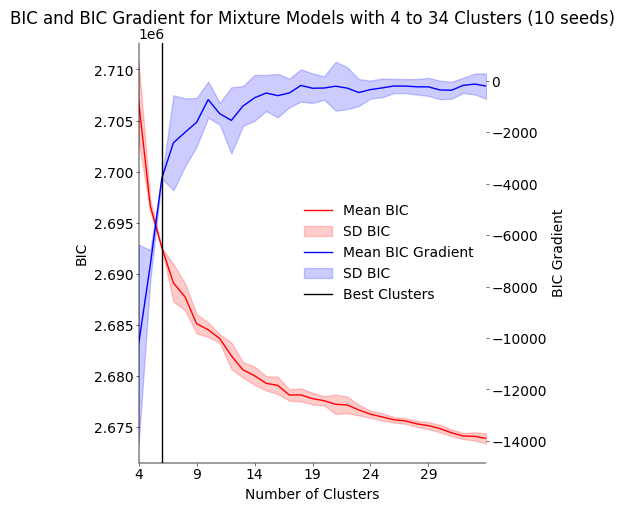

In [ ]:
# Compute mean and standard deviation along cluster sizes
mean_BIC = np.mean(BIC, axis=0)
std_BIC = np.std(BIC, axis=0)  # makes no sense if we just use one seed

bic_grad = np.apply_along_axis(
    np.gradient, axis=1, arr=BIC
)  # compute the gradient of the BIC
mean_BIC_grad = np.mean(bic_grad, axis=0)
std_BIC_grad = np.std(BIC, axis=0)

fix, ax = plt.subplots(figsize=(5, 5))
ax2 = ax.twinx()

ax.plot(K, mean_BIC, c="r", label="Mean BIC")
ax.fill_between(
    K,
    mean_BIC - std_BIC,
    mean_BIC + std_BIC,
    alpha=0.2,
    color="r",
    label="SD BIC",
)
ax2.plot(K, mean_BIC_grad, c="b", label="Mean BIC Gradient")
ax2.fill_between(
    K,
    mean_BIC_grad - std_BIC_grad,
    mean_BIC_grad + std_BIC_grad,
    alpha=0.2,
    color="b",
    label="SD BIC",
)

# added manually to show best cluster number
best_K = 6
ax2.axvline(best_K, c="k", label="Best Clusters")

ax.set_xlim([K[0], K[-1]])
ax.set_xticks(range(K[0], K[-1], 5))
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("BIC")
ax2.set_ylabel("BIC Gradient")
plt.title(
    "BIC and BIC Gradient for Mixture Models with {} to {} Clusters ({} seeds)".format(
        K[0], K[-1], num_seeds
    )
)
ax.legend(loc="center right", bbox_to_anchor=(0.8134, 0.575))
ax2.legend(loc="center right", bbox_to_anchor=(1, 0.45))
plt.show()

Interpretation: Gradient becomes more and more constant as the number of clusters increase. To avoid overfit we don't want the lowest BIC, but the one where the most amount of information is preserved. The gradient takes a plateau starting at around 9, with a small dip at 12. That means even though the BIC continues to get lower, the information gained by and increased number of clusters is very low.
To get a good value of the number of clusters to chose, we need to split in to a test and train set for the MoG and evaluate the amount of overfit depending on the number of clusters. Since this is not the task we simply take the intersection of the gradient to the BIC, which seems to be around 6. This is also from a biological point of view a reasonable number of neurons that were recorded.
Additionially, the BIC leads to a large overfit in our case as the penalty term is relatively small compared to the values of the log likelihood. Therefore the number of free parameters doesn't really have an impact on the value of the BIC.

Refit model with lowest BIC and plot data points

In [ ]:
seed = seeds[
    np.argmin(BIC[:, best_K - min_K])
]  # get the seed with the lowest BIC for 6 clusters

# Fit with 6 clusters for reasons described above:
labels, means, S, p = fit_mog(b, best_K, random_seed=seed)

Text(0.5, 0.98, 'Cluster Assignments to PC features')

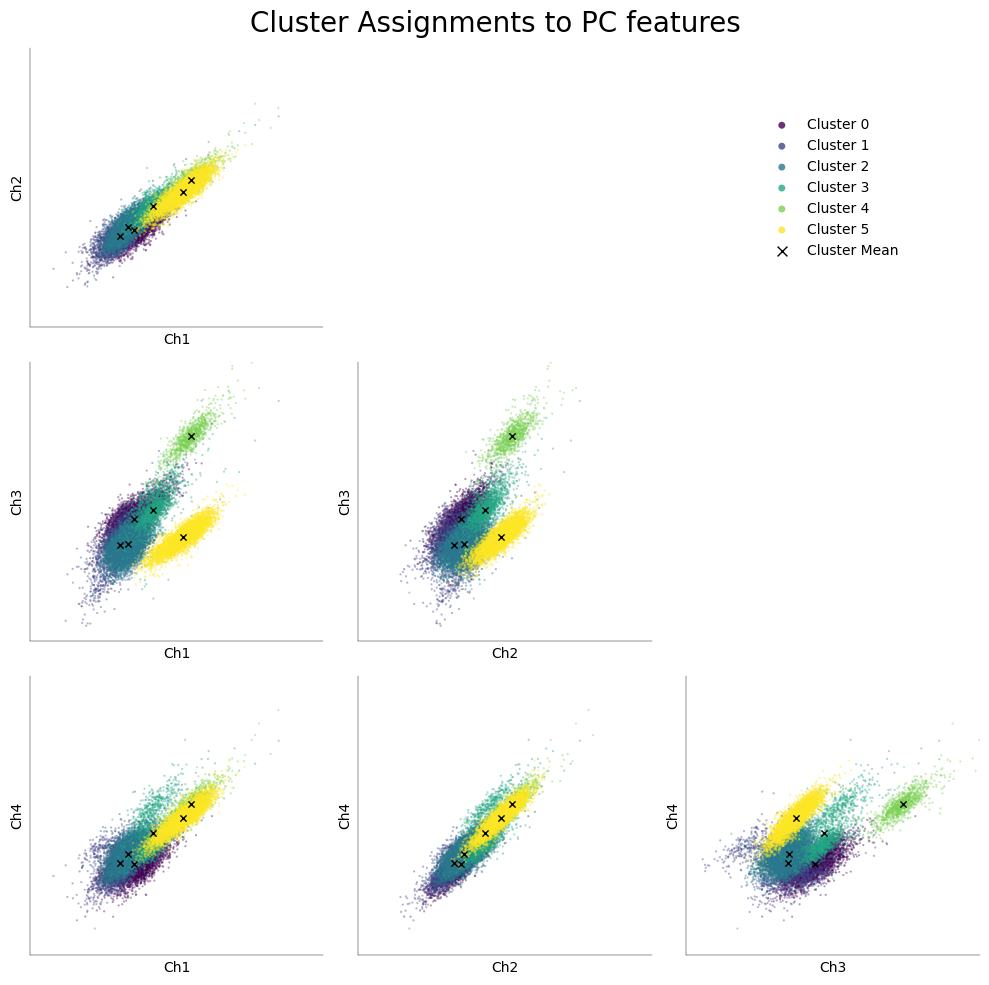

In [ ]:
# -------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all 4 channels. (2 pts)
# -------------------------------------------------------------------------------------

# Getting corresponding colors from the Viridis colormap
viridis_colors = plt.cm.viridis(np.linspace(0, 1, best_K))

# Converting RGBA colors to hex codes
color_names = [plt.cm.colors.to_hex(color) for color in viridis_colors]


mosaic = [
    ["Ch2 vs Ch1", ".", "l"],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(10, 10), layout="tight")

# indices of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

for m in np.ravel(mosaic):
    if m == ".":
        continue
    # create legend
    if m == "l":
        for l in range(best_K):
            ax[m].scatter(
                [],
                [],
                alpha=0.8,
                s=100,
                edgecolors="none",
                c=color_names[l],
                label="Cluster %s" % l,
            )
        ax[m].scatter([], [], marker="x", s=50, c="k", label="Cluster Mean")
        ax[m].legend(loc="center")
        ax[m].axis("off")
        continue

    # plot data
    yb, xb = m.split(" vs ")

    # plot for each cluster separately to preserve the color value
    for l in range(best_K):
        cluster_data = b[labels == l]
        ax[m].scatter(
            cluster_data[:, i[xb]],
            cluster_data[:, i[yb]],
            alpha=0.4,
            s=10,
            edgecolors="none",
            c=color_names[l],
        )

    ax[m].scatter(means[:, i[xb]], means[:, i[yb]], marker="x", s=20, c="k")

    ax[m].set_xlabel(xb)
    ax[m].set_ylabel(yb)
    ax[m].set_xlim((-1000, 1500))
    ax[m].set_ylim((-1000, 1500))
    ax[m].set_xticks([])
    ax[m].set_yticks([])

# create separate legend in subplot field (2,2)


fig.suptitle("Cluster Assignments to PC features", fontsize=20)

### Task 5: Cluster separation

Implement linear discriminant analysis to visualize how well each cluster is separated from its neighbors in the high-dimensional space in the function `separation()`. Project the spikes of each pair of clusters onto the axis that optimally separates those two clusters. 

Plot a matrix with pairwise separation plots, showing the histogram of the points in both clusters projected on the axis best separating the clusters (as shown in the lecture). *Hint:* Since Python 3.5+, matrix multiplications can be compactely written as `x@y`.

*Grading: 4 pts*


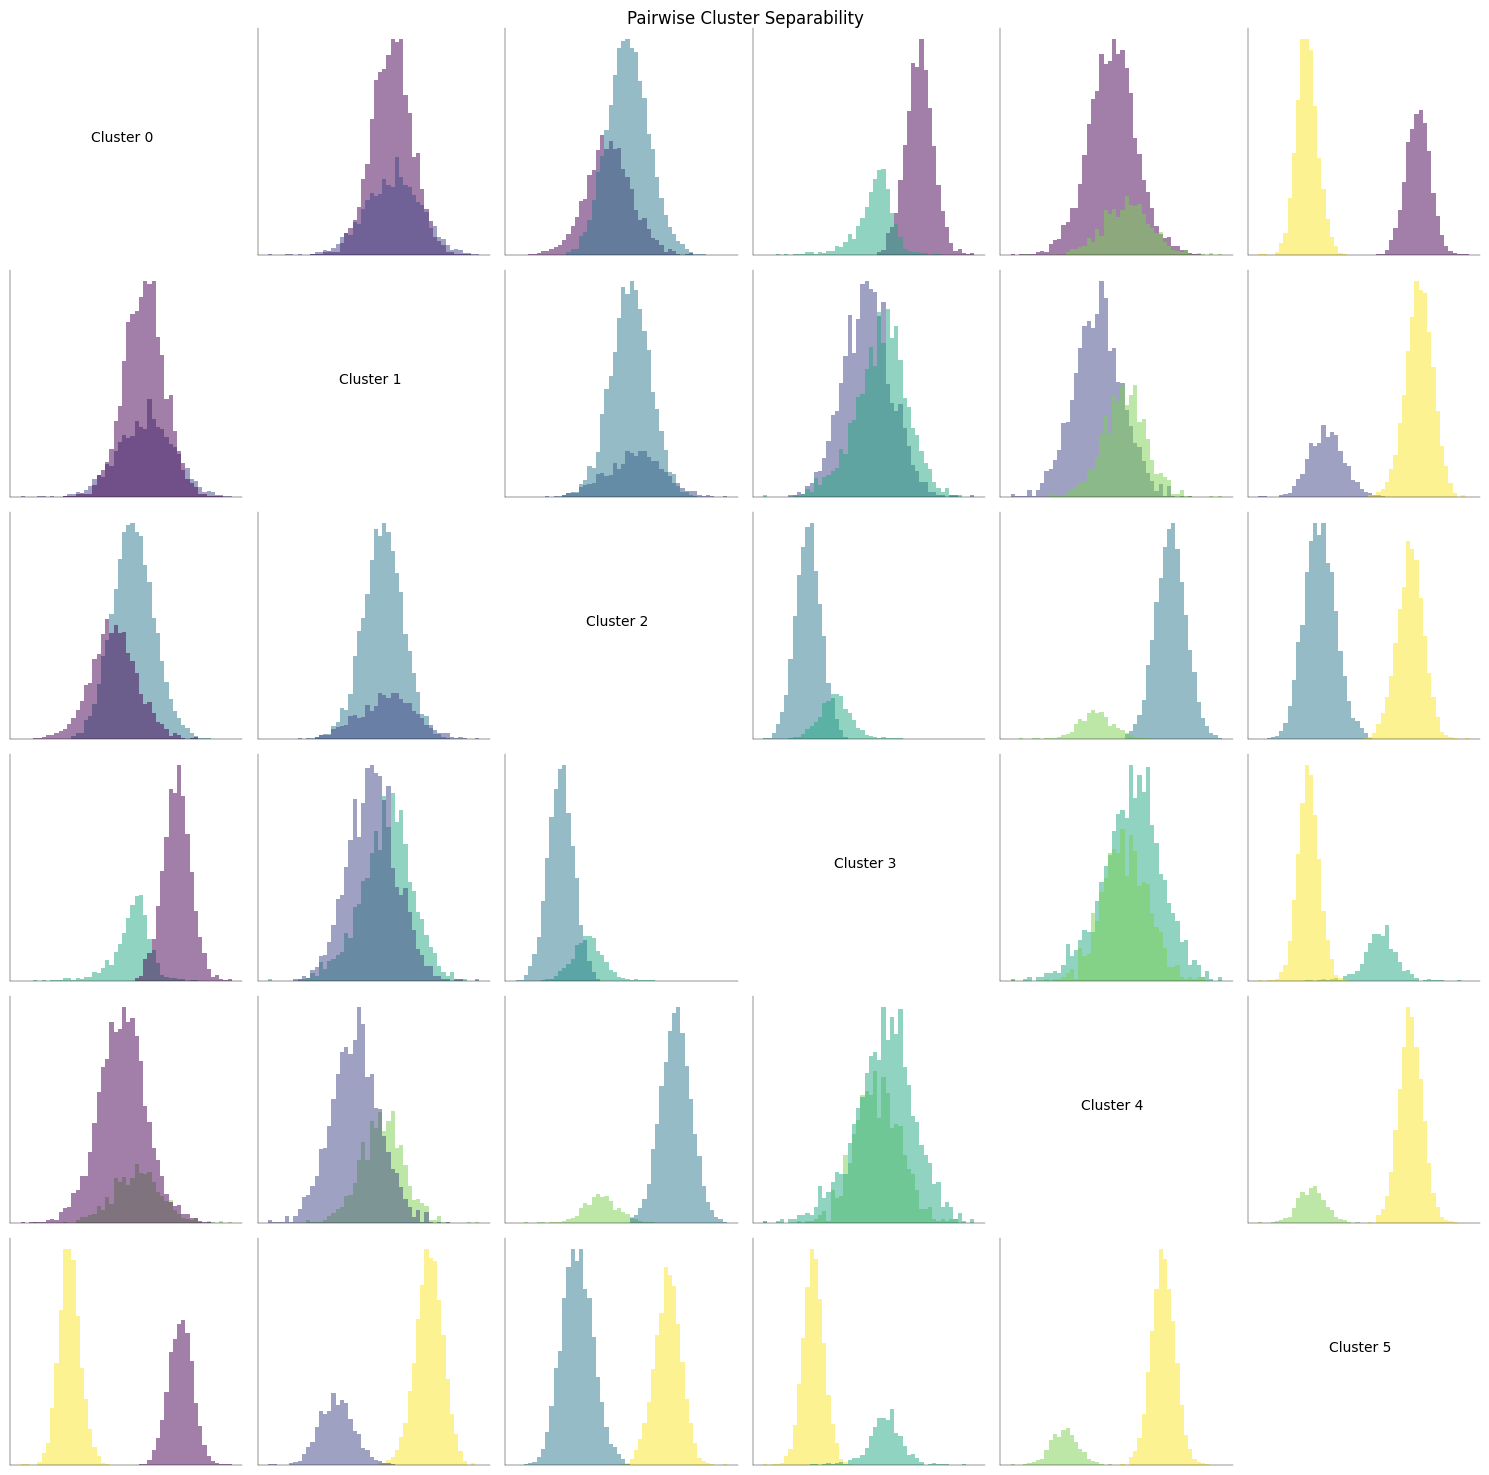

In [ ]:
# we used the following sources for our implementation of the LDA
# https://www.researchgate.net/publication/316994943_Linear_discriminant_analysis_A_detailed_tutorial
# https://sebastianraschka.com/Articles/2014_python_lda.html


def separation(
    b: np.ndarray,
    m: np.ndarray,
    S: np.ndarray,
    assignment: np.ndarray,
    n_bins: int = 50,
):
    """Calculate cluster separation by LDA.

    proj, bins = separation(b, m, S, p, assignment)
    projects the data on the LDA axis for all pairs of clusters. The result
    is normalized such that the left (i.e. first) cluster has
    zero mean and unit variances. The LDA axis is estimated from the model.
    ---

    Parameters
    ----------
    b: np.array, (n_spikes, n_features)
        Features.

    m: np.array, (n_clusters, n_features)
        Means.

    S: np.array, (n_clusters, n_features, n_features)
        Covariance.

    assignment: np.array, (n_spikes, )
        Cluster assignments / labels for each spike

    n_bins: int
        Number of bins in a lda histogram.


    Returns
    -------

    proj: np.array, (n_bins, n_clusters, n_clusters)
        computed lda histo# Comparing the cells in particular

    bins: np.array, (n_bins)
        bin times relative to center    #bins x 1
    """

    # ---------------------------------------------------------------------
    # compute the optimal separating axis for each pair of clusters (2 pts)
    # ---------------------------------------------------------------------

    n_clusters, n_features = m.shape
    fig, ax = plt.subplots(n_clusters, n_clusters, figsize=(15, 15), layout="tight")

    proj = np.zeros(
        (n_bins, n_clusters, n_clusters)
    )  # initialize the projection matrix
    bins = np.zeros((n_bins, n_clusters))

    # perform lda for each pair of clusters
    for c1 in range(n_clusters):
        for c2 in range(c1 + 1, n_clusters):
            # within class scatter matrix for the two clusters
            S_W = np.zeros((n_features, n_features))
            S_B = np.zeros((n_features, n_features))

            # mean over both clusters
            mean_both = np.mean(m[[c1, c2]], axis=0)

            for c in [c1, c2]:
                # within class variance of cluster c
                S_i = np.zeros((n_features, n_features))
                mv = m[c].reshape(n_features, 1)  # mean of cluster c

                c_data = b[assignment == c].T
                S_i = (c_data - mv) @ (c_data - mv).T
                S_W += S_i

                # between class variance
                n_c = c_data.shape[1]  # number of samples in cluster c
                S_B += n_c * (mv - mean_both) @ (mv - mean_both).T

            # eigenvectors and eigenvalues
            eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W) @ S_B)

            # sort eigenvectors by decreasing eigenvalues
            eig_pairs = [
                (np.abs(eig_vals[i].real), eig_vecs[:, i].real)
                for i in range(
                    len(eig_vals)
                )  # first eig_vals have 0.j, so we can neglect the imaginary part
            ]
            eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

            # compute transformation matrix
            W = np.hstack((eig_pairs[0][1].reshape(n_features, 1)))

            # get data from b that belongs to c1 or c2
            data_c1 = b[assignment == c1]
            data_c2 = b[assignment == c2]

            # project data on the LDA axis per cluster
            proj_c1 = data_c1 @ W
            proj_c2 = data_c2 @ W

            # -------------------------------------------
            # normalise according to first cluster (1 pt)
            # -------------------------------------------

            # get standard deviation and mean of projected first cluster
            m_proj_c1 = np.mean(proj_c1)
            std_proj_c1 = np.std(proj_c1)

            # get standard deviation and mean of projected second cluster
            m_proj_c2 = np.mean(proj_c2)
            std_proj_c2 = np.std(proj_c2)

            # naming convention: descriptor_cluster_normalized-with
            # normalize projected data according to cluster c_1
            proj_c1_c1 = (proj_c1 - m_proj_c1) / std_proj_c1
            proj_c2_c1 = (proj_c2 - m_proj_c1) / std_proj_c1

            # normalize projected data according to cluster c_2
            proj_c1_c2 = (proj_c1 - m_proj_c2) / std_proj_c2
            proj_c2_c2 = (proj_c2 - m_proj_c2) / std_proj_c2

            # we compute the hist_range per cluster comparison to show the distance between both clusters

            # # get range of histograms for both clusters normalized to cluster c1
            range_min = np.min(np.concatenate([proj_c1_c1, proj_c2_c1]))
            range_max = np.max(np.concatenate([proj_c1_c1, proj_c2_c1]))
            hist_range_c1 = (range_min, range_max)

            # get range of histograms for both clusters normalized to cluster c2
            range_min = np.min(np.concatenate([proj_c1_c2, proj_c2_c2]))
            range_max = np.max(np.concatenate([proj_c1_c2, proj_c2_c2]))
            hist_range_c2 = (range_min, range_max)

            # calculate histogram per cluster for data normalized to cluster c1
            hist_c1_c1, bins_c1 = np.histogram(
                proj_c1_c1, bins=n_bins, range=hist_range_c1
            )
            hist_c2_c1, _ = np.histogram(proj_c2_c1, bins=bins_c1, range=hist_range_c1)

            # calculate histogram per cluster for data normalized to cluster c2
            hist_c2_c2, bins_c2 = np.histogram(
                proj_c2_c2, bins=n_bins, range=hist_range_c2
            )
            hist_c1_c2, _ = np.histogram(proj_c1_c2, bins=bins_c2, range=hist_range_c2)

            # write histogram to proj
            proj[:, c1, c1] = hist_c1_c1
            proj[:, c1, c2] = hist_c2_c1
            proj[:, c2, c1] = hist_c1_c2
            proj[:, c2, c2] = hist_c2_c2

            # --------------------------------------
            # plot histograms on optimal axis (1 pt)
            # --------------------------------------

            # normalized to cluster c1
            c1_width = abs(bins_c1[1] - bins_c1[0])
            # plot first cluster histogram
            ax[c1, c2].bar(
                bins_c1[:-1],
                hist_c1_c1,  # proj[:, c1, c1],
                width=c1_width,
                alpha=0.5,
                label=f"Cluster {c1}",
                align="edge",
                color=color_names[c1],
            )
            # plot second cluster histogram
            ax[c1, c2].bar(
                bins_c1[:-1],
                hist_c2_c1,  # proj[:, c1, c2],
                width=c1_width,
                alpha=0.5,
                label=f"Cluster {c2}",
                align="edge",
                color=color_names[c2],
            )

            # flipped version: normalized to cluster c2
            c2_width = abs(bins_c2[1] - bins_c2[0])
            # plot first cluster histogram
            ax[c2, c1].bar(
                bins_c2[:-1],
                hist_c2_c2,  # proj[:, c2, c2],
                width=c2_width,
                alpha=0.5,
                label=f"Cluster {c2}",
                align="edge",
                color=color_names[c2],
            )
            # plot second cluster histogram
            ax[c2, c1].bar(
                bins_c2[:-1],
                hist_c1_c2,  # proj[:, c2, c1],
                width=c2_width,
                alpha=0.5,
                label=f"Cluster {c1}",
                align="edge",
                color=color_names[c1],
            )
            # in our opinion, axis values are not necessary here, because we are just interested in how the clusters are separable
            # if you want to see the axis values, just uncomment the following four lines
            ax[c1, c2].set_xticks([])
            ax[c1, c2].set_yticks([])
            ax[c2, c1].set_xticks([])
            ax[c2, c1].set_yticks([])

        ax[c1, c1].text(0.35, 0.5, "Cluster %s" % c1)
        ax[c1, c1].axis("off")
    ax[n_clusters - 1, n_clusters - 1].axis("off")
    plt.suptitle("Pairwise Cluster Separability")
    plt.show()

    return proj, np.zeros(n_bins)  # sorry, didn't understand what this is for


proj, _ = separation(b, means, S, labels)

It can be seen that clusters 0 to 4 are still difficult to separate. Cluster 5, on the other hand, is clearly separated from the others.

### Comment about the normalization technique:
In the normalization approach shown here, there is no visible difference between the cluster combination pairs (c1, c2) <-> (c2, c1). This is because we have always applied the bin range of the histograms to the entire range of both clusters. If we only ever took the range of the first cluster of a pair, values of the second cluster that exceed this range would be summarized in the last bin. The usefulness of such a representation is debatable. Normalizing all clusters to the cluster with index 0 does not make sense in our eyes either, as significantly smaller histograms are almost impossible to see. Since we are interested in the pairwise comparison, we have left the normalization per pair. This also leads to the opinion that a uniform axes scale is not conducive.